# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。

## モジュールと関数の用意

In [7]:
from datetime import datetime
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd

%matplotlib inline

In [8]:
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def make_ohlc_by_step(y, step=60):
    """make_ohlc_by_step(y, step) -> numpy.2darray
    calculate OHLC from a given array-like object
    
    Parameters
    ----------
    y : pandas.Series
        target data series
    step : int (default : 60)
        step for OHLC
    
    Returns
    -------
    ohlc_ : numpy.2darray
        OHLC data
    """
    if isinstance(y, list):
        y = np.array(y)
    if step <= 0:
        raise ValueError("'step' must be larger than 0.")
    if not isinstance(step, int):
        raise TypeError("'step' must be integer.")
    nbr_of_candles = len(y) // step
    if len(y) % step != 0:
        nbr_of_candles += 1
    
    def f(x):
        if len(x) > 1:
            return np.array([x[0], x.max(), x.min(), x[-1]])
        else:
            return np.array([x[0], x[0], x[0], x[0]])
    
    ohlc_ = np.zeros((nbr_of_candles, 4), dtype=int)
    for ii in range(nbr_of_candles - 1):
        y_ = y[ii*step:(ii+1)*step].copy()
        y_.dropna(how="any");
        if len(y_.values) >= 1:
            ohlc_[ii] = f(y_.values)
        elif ii != 0:
            ohlc_[ii] = ohlc_[ii-1].copy()
        else:
            ohlc_[ii] = np.array([0,0,0,0])
    ii += 1
    y_ = y[ii*step:].copy()
    y_.dropna(how="any");
    if len(y_.values) >= 1:
        ohlc_[ii] = f(y_.values)
    elif ii != 0:
        ohlc_[ii] = ohlc_[ii-1].copy()
    else:
        ohlc_[ii] = np.array([0,0,0,0])

    return ohlc_

def pickup_by_step(y, step=60):
    """pickup_by_step(y, step) -> numpy.1darray
    pick up values from a given data series every 'step'
    
    Parameters
    ----------
    y : pandas.Series
        target data series
    step : int (default : 60)
        step
    
    Returns
    -------
    picked-up values : numpy.1darray
    """
    if isinstance(y, list):
        y = np.array(y)
    if step <= 0:
        raise ValueError("'step' must be larger than 0.")
    if not isinstance(step, int):
        raise TypeError("'step' must be integer.")
    nbr_of_candles = len(y) // step
    if len(y) % step != 0:
        nbr_of_candles += 1
    y_ = []
    for ii in range(nbr_of_candles - 1):
        var_ = y[ii*step:(ii+1)*step:].copy()
        var_.dropna(how="any")
        if len(var_.values) != 0:
            y_.append(var_.values[-1])
        else:
            y_.append(y_[-1])
    
    ii += 1
    var_ = y[ii*step:].copy()
    var_.dropna(how="any")
    if len(var_.values) != 0:
        y_.append(var_.values[-1])
    else:
        y_.append(y_[-1])

    return np.array(y_)

def make_ohlc_dataframe_by_step(data, step=60):
    """make_ohlc_dataframe_by_step(data, step) -> pandas.DataFrame
    make a DataFrame object including the following columns from a given DataFrame object 'data':
    'Date', 'Open', 'High',
    
    Parameters
    ----------
    data : pandas.DataFrame
        'data' must have at least the two field: 'ltp' and 'timestamp'.
        Every element in 'timestamp' column must have "%Y-%m-%dT%H:%M:%S" format.
    step : int (default : 60)
        step for OHLC
    
    Returns
    -------
    df : pandas.DataFrame
    """
    ohlc_ = make_ohlc_by_step(data["ltp"], step)
    timestamp = pickup_by_step(data["timestamp"], step)
#     timestamp_mdates = [mdates.date2num(datetime.strptime(ts.split(".")[0], "%Y-%m-%dT%H:%M:%S")) for ts in timestamp]
    columns = ["Open", "High", "Low", "Close"]
    df = pd.DataFrame(ohlc_, columns=columns)
    df["Date"] = timestamp
#     df["Date"] = np.array(timestamp_mdates)
    return df

class dataAdapter(object):
    """dataAdapter(object)
    base class for adapter of dataset obtained from bitFlyer by the ticker API
    """
    def __init__(self, data, step=60):
        """__init__(self, filepath, step=60) -> None
        initialize this class
        
        Parameters
        ----------
        data : str or pandas.DataFrame
            if str then it is treated as path of file
        step : int
            step for making OHLC dataset
        """
        self.step = step
        self.loadData(data)
    
    @property
    def original_data(self):
        """original_data(self) -> pandas.DataFrame
        return the original data
        """
        return self._data
    
    def loadData(self, *args):
        """loadData(self, *args) -> None
        load data
        
        Parameters
        ----------
        args[0] : str or pandas.DataFrame
            if str then it is treated as path of file
        """
        if len(args) == 0:
            return
        if isinstance(args[0], str):
            self._data = pd.read_csv(filepath, index_col=0)
        elif isinstance(args[0], pd.DataFrame):
            self._data = args[0]
        self.__makeOhlcDataFrameByStep()
    
    def __makeOhlcDataFrameByStep(self):
        """__makeOhlcDataFrameByStep(self) -> None
        internal wrapper function of make_ohlc_dataframe_by_step(data, step)
        """
        self._df_OHLC = make_ohlc_dataframe_by_step(self._data, self.step)
    
    @property
    def df_OHLC(self):
        """df_OHLC(self) -> pd.DataFrame
        return the OHLC dataset as pandas.DataFrame
        """
        return self._df_OHLC

In [143]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [10]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["Close"] - dataFrame["Open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [39]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## データの読み込み

In [11]:
fldrpath = r"C:\Users\take9\Desktop\data_"
filelist = glob.glob(os.path.join(fldrpath, "*.csv"))
print(len(filelist))

2654


In [12]:
# data = None
# start_file = 0
# nbr_of_files = 2654
# for ii in range(start_file, start_file + nbr_of_files):
#     data_ = pd.read_csv(filelist[ii], index_col=0)
#     if data is None:
#         data = data_
#     else:
#         data = pd.concat([data, data_], ignore_index=True, sort=True)

In [13]:
# len(data)

In [14]:
# data["timestamp"][100:110].isnull()

In [15]:
# df = make_ohlc_dataframe_by_step(data)
# df.head(), len(df)

In [16]:
# df.to_csv("../data/minute/OHLC_20181211.csv")

In [186]:
df = pd.read_csv("../data/minute/OHLC_20181211.csv", index_col=0)
df.head()

,Open,High,Low,Close,Date
0,729874,730119,729874,730000,2018-07-16T07:04:16.117
1,730002,730175,730002,730171,2018-07-16T07:05:20.477
2,730171,730503,730092,730446,2018-07-16T07:06:20.55
3,730422,730518,730345,730453,2018-07-16T07:08:50.733
4,730420,730509,730265,730335,2018-07-16T07:09:50.997


In [185]:
df.tail()

,Open,High,Low,Close,Date
159133,470707,471188,469350,469487,2018-11-23T05:12:56.59
159134,469556,469575,468234,468615,2018-11-23T05:13:56.417
159135,468380,468994,468000,468211,2018-11-23T05:14:56.773
159136,468308,468397,467227,467592,2018-11-23T05:15:56.49
159137,467984,468000,467446,467589,2018-11-23T05:16:15.693


７月半ばから１１月半ばの４か月と一週間分のデータを対象とする。

## 前回の分析の最後

In [18]:
N1 = 5; N2 = 20;
ema1 = calc_EMA(df["Close"].values, N1)
ema2 = calc_EMA(df["Close"].values, N2)

In [19]:
columns = ["Date", "Open", "High", "Low", "Close"]

df_ = df.copy()
tuples = [tuple(x) for x in df_[columns].values]
x = df_["Date"].values
cross_points = find_cross_points(ema1, ema2)

In [20]:
ind_ = cross_points != 0
a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
a_k

array([[    10,     -1],
       [    24,      1],
       [    35,     -1],
       ...,
       [159096,     -1],
       [159100,      1],
       [159102,     -1]])

In [21]:
close_ = df["Close"]

N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
    dec_ext[ii] = dec[ind1]

(-10000, 10000)

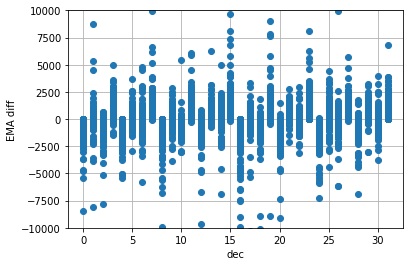

In [22]:
plt.plot(dec_ext, ema_diff_ext, "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.grid(True)
plt.ylim(-10000, 10000)

データを見直したら、実は多少は特徴が出ている模様。

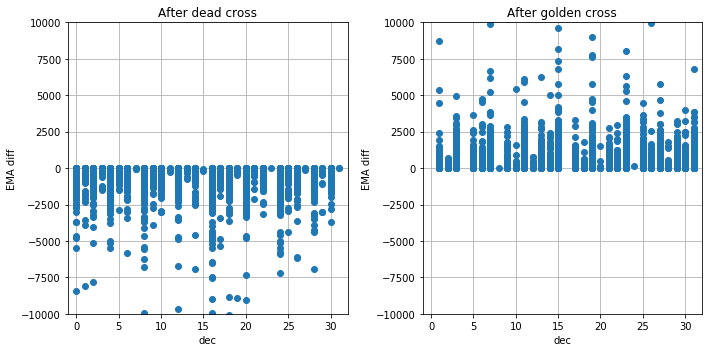

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], ema_diff_ext[::2], "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 10000)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], ema_diff_ext[1::2], "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 10000)
plt.grid(True)

plt.tight_layout()

特定のパターンでは一方向にのみ値が出ている。   
パターンがないまたはパターンがあってもdiffが小さいものは、   
そのパターンからの発展が弱いということを意味する。   

In [24]:
histo_dead, x_bin = np.histogram(dec_ext[::2], bins=np.arange(2**N_dec+1))
histo_golden, x_bin = np.histogram(dec_ext[1::2], bins=np.arange(2**N_dec+1))

histo_diff = histo_golden - histo_dead

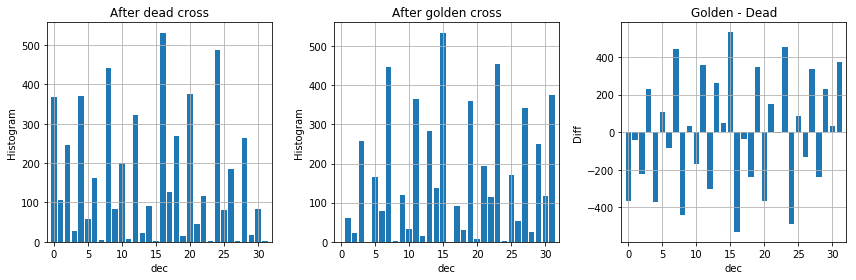

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(x_bin[:-1], histo_dead)
plt.xlabel("dec")
plt.ylabel("Histogram")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.subplot(132)
plt.bar(x_bin[:-1], histo_golden)
plt.xlabel("dec")
plt.ylabel("Histogram")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.subplot(133)
plt.bar(x_bin[:-1], histo_diff)
plt.xlabel("dec")
plt.ylabel("Diff")
plt.title("Golden - Dead")
plt.xlim(-1, 2**N_dec)
plt.grid(True)

plt.tight_layout()

In [26]:
bin_golden = []
bin_dead = []

threshold = 0.8

for ii in range(2**N_dec):
    if histo_diff[ii] > 0 and histo_diff[ii]/(histo_golden[ii]+histo_dead[ii]) > threshold:
        bin_golden.append("{0:05d}".format(int(format(ii, "b"))))
    elif histo_diff[ii] < 0 and histo_diff[ii]/(histo_golden[ii]+histo_dead[ii]) < -threshold:
        bin_dead.append("{0:05d}".format(int(format(ii, "b"))))

In [27]:
bin_golden, bin_dead, len(bin_golden), len(bin_dead)

(['00011',
  '00111',
  '01011',
  '01101',
  '01111',
  '10011',
  '10111',
  '11011',
  '11101',
  '11111'],
 ['00000',
  '00010',
  '00100',
  '01000',
  '01100',
  '10000',
  '10100',
  '11000',
  '11100'],
 10,
 9)

これらのパターンは、勝ち確定のパターンではなく、golden cross/dead crossの前に現れやすいパターンを示している。   
このパターンがあれば必ず後にgolden cross/dead crossが続くということを示しているのではなく、   
cross pointが現れたときにその前にこれらのパターンがあると、その後に安定してトレンドが発達する可能性があるということを意味する。

# 利確のパターン
Cross pointの前に現れやすいパターンがあるといっても、   
それで利確になるタイミングがつかめるかどうかを知るにはもう少し解析を進める必要がある。   
Cross pointの次のタイミングで入ったとして、その後の対のcrossに入るまでにEMAの差の最大・最小が現れるタイミングでのltpの差分と、   
これらのパターンの間に相関があるかどうかを検討する。

## 値の取り出し

In [182]:
close_ = df["Close"]
open_ = df["Open"]

N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)
open_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
    dec_ext[ii] = dec[ind1]
    
    if len(o_) > 1:
        open_ext[ii] = o_.values[1]
    else:
        open_ext[ii] = o_.values[0]
    tm_ext[ii] = min(o_.values[tm], c_.values[tm])

benefits = tm_ext - open_ext
benefits[np.abs(benefits)>1e5] = 0.0
ema_diff_ext[np.abs(ema_diff_ext)>1e5] = 0.0

## 散布図

(-50000, 50000)

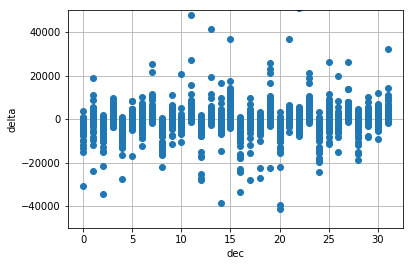

In [170]:
plt.figure()
plt.plot(dec_ext, benefits, "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.grid(True)
plt.ylim(-50000, 50000)

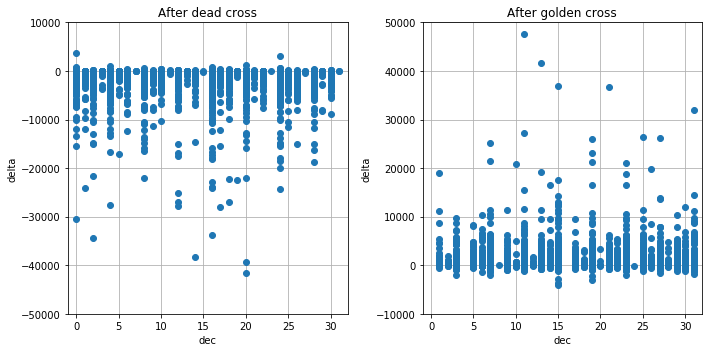

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], benefits[::2], "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-50000, 10000)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], benefits[1::2], "o")
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 50000)
plt.grid(True)

plt.tight_layout()

わりとがっつりと利益が出そうな気がするが、、   
それぞれの場合で平均と分散、中央値を出してみる。

## 平均と分散

In [31]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

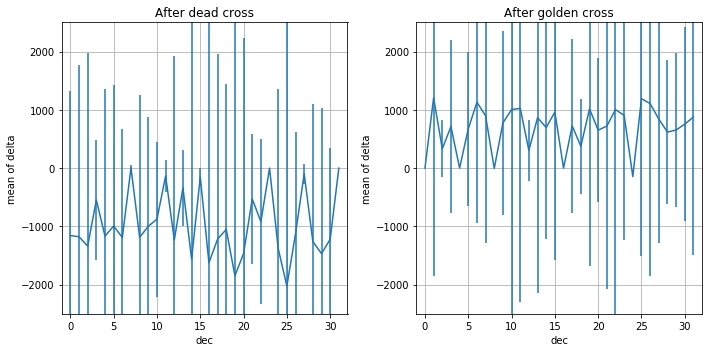

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

平均的には、dead crossの後は1000程度、golden crossの後は500~1000程度の差分が見込まれる。

## 箱ひげ図
平均と分散は有用ではあるのだが、外れ値がいるとどうしても幅が広いという印象を与えがちである。   
そのようなときは箱ひげ図が使える。

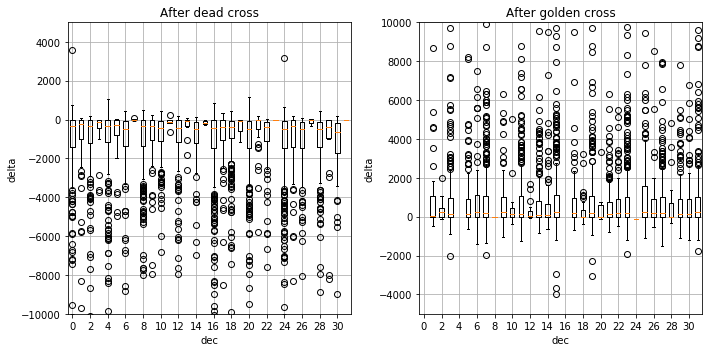

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [184]:
print(-benefits[::2].sum(), benefits[1::2].sum())
print(-benefits[::2].sum() + benefits[1::2].sum())

6415621 4484468
10900089


1 BTC で購入していたと仮定すると、うまくいけば１千万円稼げていたことになる。   
0.5 BTCでも５百万円である。１年通せば１千５百万。。   
一か月あたりの稼ぎは２５０万円（0.5BTCで１２５万円）。

## EMAの差が最大・最小になった直後に約定するとどうなるか

In [175]:
close_ = df["Close"]
open_ = df["Open"]

N_dec = 5
dec = symbolize(df_, N_dec)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)
open_ext = np.zeros(len(a_k), int)
tm_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    o_ = open_[ind1:ind2]
    c_ = close_[ind1:ind2]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
    dec_ext[ii] = dec[ind1]
    
    if len(o_) > 1:
        open_ext[ii] = o_.values[1]
    else:
        open_ext[ii] = o_.values[0]
    if tm != len(o_) - 1:
        tm_ext[ii] = min(o_.values[tm+1], c_.values[tm+1])
    else:
        tm_ext[ii] = min(o_.values[tm], c_.values[tm])

benefits = tm_ext - open_ext
benefits[np.abs(benefits)>1e5] = 0.0
ema_diff_ext[np.abs(ema_diff_ext)>1e5] = 0.0

In [35]:
stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = benefits[::2][ii]
    list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

for ii in range(len(list_ext_dead)):
    arr = list_ext_dead[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_dead[ii] = arr[ind]
        stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = benefits[1::2][ii]
    list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

for ii in range(len(list_ext_golden)):
    arr = list_ext_golden[ii]
    if len(arr) != 0:
        ind = np.abs(arr) <=100000
        list_ext_golden[ii] = arr[ind]
        stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

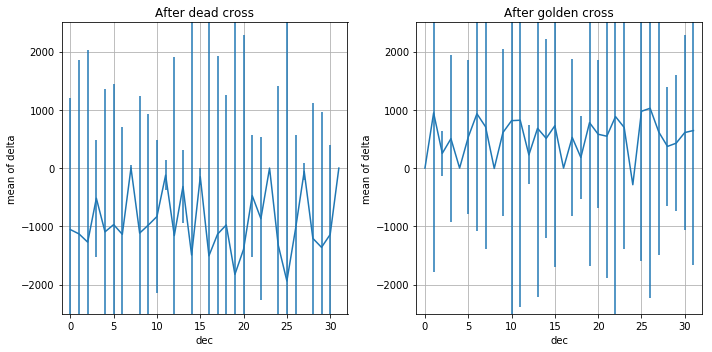

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

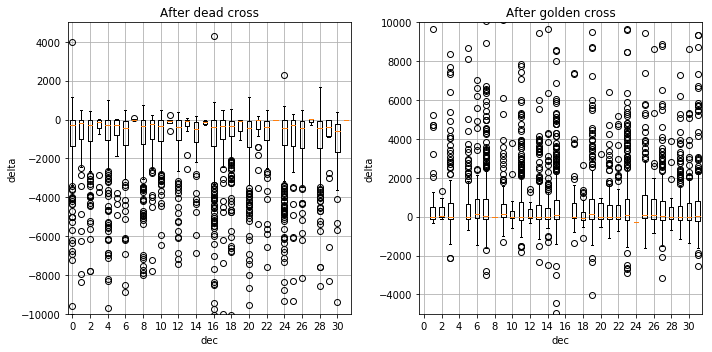

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

### 仮にすべてのcross points で理想的なエントリー・約定を行えた場合の利益は？
1 BTCを購入したとする。

In [180]:
print(-benefits[::2].sum(), benefits[1::2].sum())

6036270 3451372


## EMA1-EMA2との相関

Cov: [[1.         0.77543727]
 [0.77543727 1.        ]]


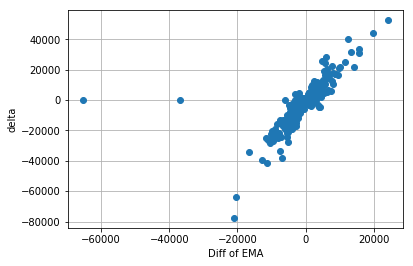

In [178]:
plt.figure()
plt.plot(ema_diff_ext, benefits, "o")
plt.xlabel("Diff of EMA")
plt.ylabel("delta")
plt.grid(True)
plt.ylim(-50000, 50000)
plt.xlim(-25000, 25000)
print("Cov:", np.corrcoef(ema_diff_ext, benefits))

EMA1-EMA2の最大・最小とdeltaの間には明瞭な相関がある（当たり前か）。   
外れるようなものがあれば、それはそれで興味深かっただろうが。

## まとめ
* Dead crossとgolden crossの両方とも、その前のいくつかのOHLCを見たときに現れないパターンがある。
* 平均的には、cross pointが現れたOHLCの直後にエントリーをすると、EMA(N=5,20)の差が最大または最小となる点において約定すると、dead crossの後は1000程度、golden crossの後は500~1000程度の利益が見込まれる。
    + 約定のタイミングが最大・最小となる点より一つずれると、どちらも利益が下がるものの平均的には利確になりうる。
* したがってcross pointが現れたときに、見込みのあるパターンが形成されているならば出現直後にエントリーして、EMAの差が最大または最小となる点の前後で約定することで利益を得られそうである。

# 種々の相関

In [112]:
maxtab0, mintab0 = peakdet(close_, 10)
len(mintab0)

38245

In [135]:
maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
maxtab_ema_diff = maxtab_ema_diff.astype(int)
mintab_ema_diff = mintab_ema_diff.astype(int)

In [136]:
mintab_ema_diff[index, 0]

array([ 6, 14, 20, 36, 51, 66, 72, 79])

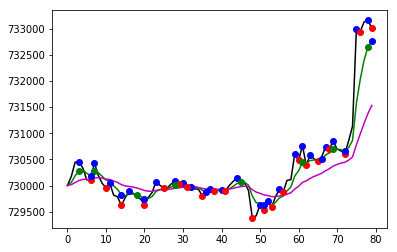

In [137]:
start = 0
end = 80
plt.plot(close_[start:end], "k")
plt.plot(ema1[start:end], "g")
plt.plot(ema2[start:end], "m")

index = (maxtab0[:, 0]>=start)&(maxtab0[:, 0]<end)
plt.plot(maxtab0[index, 0], maxtab0[index, 1], "bo")
index = (mintab0[:, 0]>=start)&(mintab0[:, 0]<end)
plt.plot(mintab0[index, 0], mintab0[index, 1], "ro")

index = (maxtab_ema_diff[:, 0]>=start)&(maxtab_ema_diff[:, 0]<end)
plt.plot(maxtab_ema_diff[index, 0], ema1[maxtab_ema_diff[index, 0]], "go")
index = (mintab_ema_diff[:, 0]>=start)&(mintab_ema_diff[:, 0]<end)
plt.plot(mintab_ema_diff[index, 0], ema1[mintab_ema_diff[index, 0]], "bo")

In [124]:
max_min_count = np.zeros(len(a_k), int)
max_min_pos = [np.empty(0, dtype=int)] * len(a_k)
max_min_value = [np.empty(0, dtype=int)] * len(a_k)
max_min_distance = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    if v < 0:
        index = (mintab0[:, 0]>=ind1)&(mintab0[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            max_min_pos[ii] = mintab0[index, 0].copy()
            max_min_value[ii] = mintab0[index, 1].copy()
            max_min_count[ii] = count
        else:
            max_min_pos[ii] = np.array([0])
            max_min_count[ii] = 0
    else:
        index = (maxtab0[:, 0]>=ind1)&(maxtab0[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            max_min_pos[ii] = maxtab0[index, 0].copy()
            max_min_value[ii] = maxtab0[index, 1].copy()
            max_min_count[ii] = count
        else:
            max_min_pos[ii] = np.array([0])
            max_min_count[ii] = 0
    
    if v < 0:
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
    else:
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
    max_min_distance[ii] = tm + 1

## パターンと最大値の距離

注：距離が30ということは30分後に現れるということ。

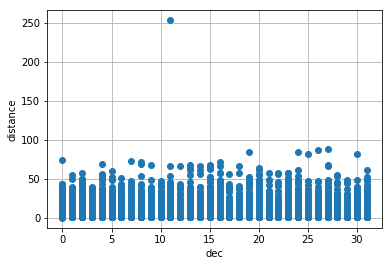

In [125]:
plt.figure()
plt.plot(dec_ext, max_min_distance, "o")
plt.xlabel("dec")
plt.ylabel("distance")
plt.grid(True)
# plt.ylim(-50000, 50000)

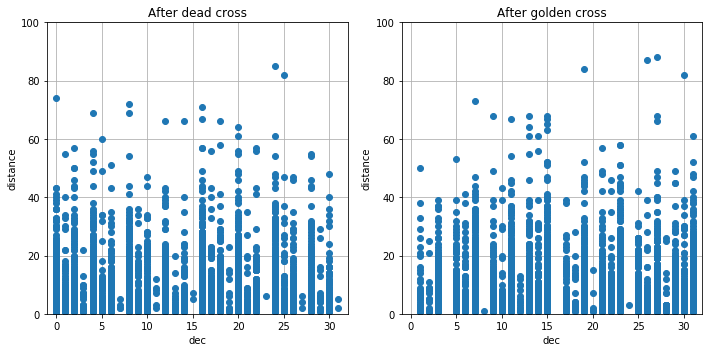

In [76]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], max_min_distance[::2], "o")
plt.xlabel("dec")
plt.ylabel("distance")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 100)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], max_min_distance[1::2], "o")
plt.xlabel("dec")
plt.ylabel("distance")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 100)
plt.grid(True)

plt.tight_layout()

### 箱ひげ図で見る

In [77]:
list_distance_dead = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[::2]):
    v = max_min_distance[::2][ii]
    list_distance_dead[ind] = np.append(list_distance_dead[ind], v)

list_distance_golden = [np.empty(0, dtype=float)] * 2**N_dec
for ii, ind in enumerate(dec_ext[1::2]):
    v = max_min_distance[1::2][ii]
    list_distance_golden[ind] = np.append(list_distance_golden[ind], v)

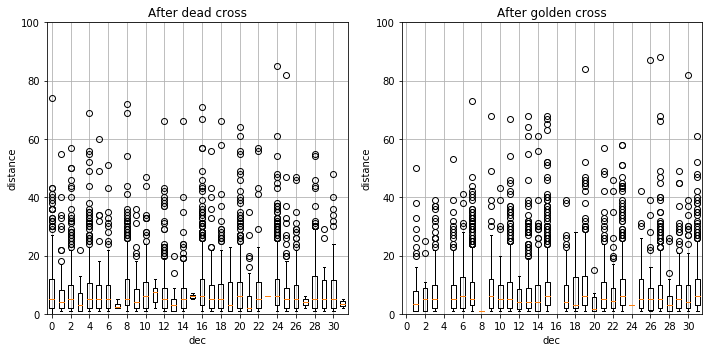

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_distance_dead))
plt.xlabel("dec")
plt.ylabel("distance")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(0, 100)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_distance_golden))
plt.xlabel("dec")
plt.ylabel("distance")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(0, 100)
plt.grid(True)

plt.tight_layout()

## パターンと最大値の個数

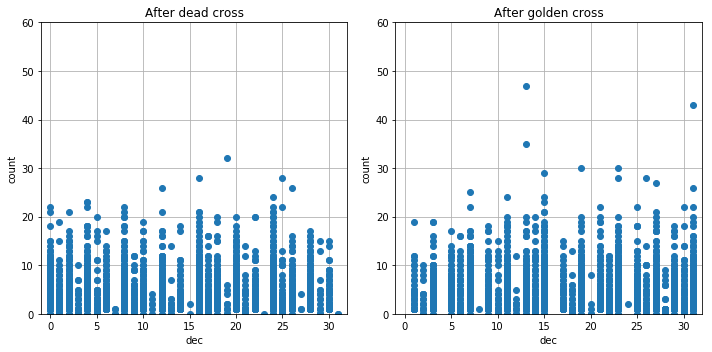

In [139]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], max_min_count[::2], "o")
plt.xlabel("dec")
plt.ylabel("count")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 60)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], max_min_count[1::2], "o")
plt.xlabel("dec")
plt.ylabel("count")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 60)
plt.grid(True)

plt.tight_layout()

## EMA_diff の場合

In [140]:
max_min_ema_count = np.zeros(len(a_k), int)
max_min_ema_pos = [np.empty(0, dtype=int)] * len(a_k)
max_min_ema_value = [np.empty(0, dtype=int)] * len(a_k)
max_min_ema_distance = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    if v < 0:
        index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            max_min_ema_pos[ii] = mintab_ema_diff[index, 0].copy()
            max_min_ema_value[ii] = mintab_ema_diff[index, 1].copy()
            max_min_ema_count[ii] = count
        else:
            max_min_ema_pos[ii] = np.array([0])
            max_min_ema_count[ii] = 0
    else:
        index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
        count = index.sum()
        if count > 0:
            max_min_ema_pos[ii] = maxtab_ema_diff[index, 0].copy()
            max_min_ema_value[ii] = maxtab_ema_diff[index, 1].copy()
            max_min_ema_count[ii] = count
        else:
            max_min_ema_pos[ii] = np.array([0])
            max_min_ema_count[ii] = 0
    
    if v < 0:
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
    else:
        tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
    max_min_ema_distance[ii] = tm + 1

### 個数

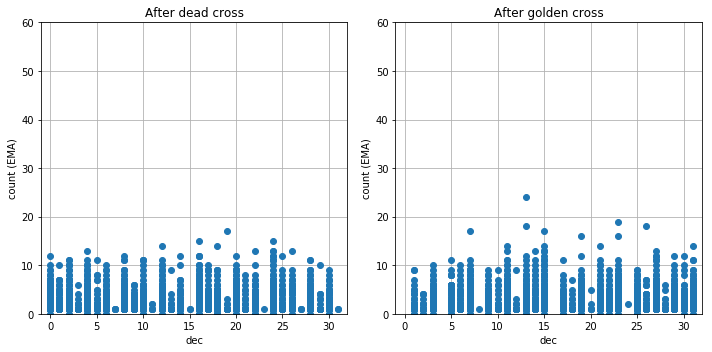

In [141]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], max_min_ema_count[::2], "o")
plt.xlabel("dec")
plt.ylabel("count (EMA)")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 60)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], max_min_ema_count[1::2], "o")
plt.xlabel("dec")
plt.ylabel("count (EMA)")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(0, 60)
plt.grid(True)

plt.tight_layout()

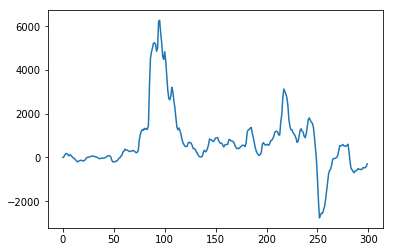

In [142]:
plt.plot(ema_diff[0:300])

CloseにしてもENA diffにしても、パターンと強い相関があるかどうかは明瞭でない。

## 傾き vs パターン

In [146]:
ema_diff_diff = np.zeros(len(ema_diff))
ema_diff_diff[1:] = np.diff(ema_diff)

In [166]:
tendency = np.zeros(len(a_k))

for ii in range(len(a_k)):
    v = ema_diff_diff[a_k[ii][0]]
    if np.abs(v) > 1e5:
        tendency[ii] = 0
    else:
        tendency[ii] = v

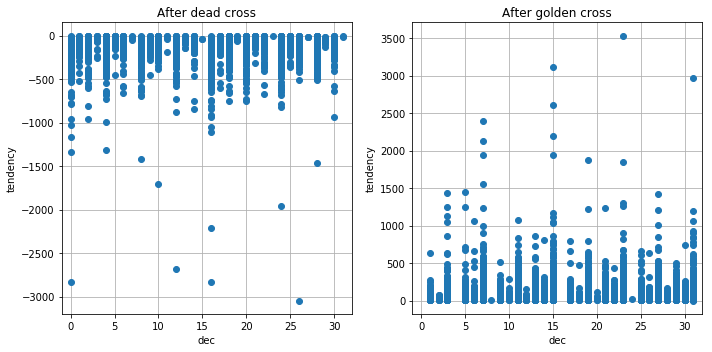

In [163]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(dec_ext[::2], tendency[::2], "o")
plt.xlabel("dec")
plt.ylabel("tendency")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
# plt.ylim(0, 60)
plt.grid(True)

plt.subplot(122)
plt.plot(dec_ext[1::2], tendency[1::2], "o")
plt.xlabel("dec")
plt.ylabel("tendency")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
# plt.ylim(0, 60)
plt.grid(True)

plt.tight_layout()

パターンに固有の傾きがあるというわけではなさそうである。

## 傾き vs 差分

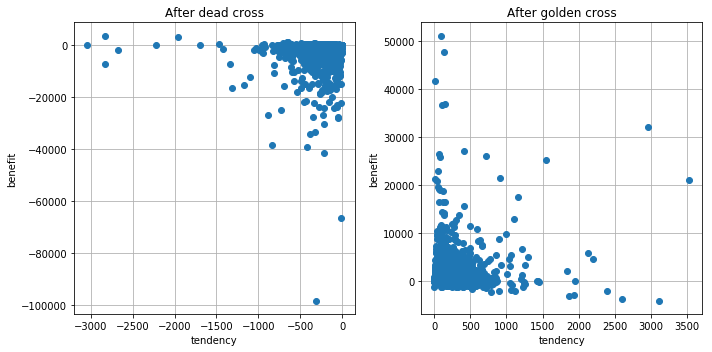

In [171]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(tendency[::2], benefits[::2], "o")
plt.xlabel("tendency")
plt.ylabel("benefit")
plt.title("After dead cross")
# plt.xlim(-1, 2**N_dec)
# plt.ylim(0, 60)
plt.grid(True)

plt.subplot(122)
plt.plot(tendency[1::2], benefits[1::2], "o")
plt.xlabel("tendency")
plt.ylabel("benefit")
plt.title("After golden cross")
# plt.xlim(-1, 2**N_dec)
# plt.ylim(0, 60)
plt.grid(True)

plt.tight_layout()

悲しいことに、傾きが大きすぎても利益が見込めないときがある。   
これは傾きが大きすぎる時にはすでに勢いを失っている場合があることに起因するのかもしれない。   
詳しくはグラフを見る必要がある。

# 三体相関